# Introduction to Fourier Neural Operator
 
Traditional neural networks, like CNNs and RNNs, are designed to work with fixed-size inputs such as images or sequences, which are essentially just long lists of numbers. Because of this, they struggle when trying to learn solutions to partial differential equations (PDEs), which involve functions defined over continuous spaces (like time or space) and can vary in resolution or size. Neural Operators are a new kind of neural network designed to handle this challenge. Instead of learning mappings between fixed-length vectors, they learn mappings between entire functions, making them much better suited for solving PDEs, even when the input data comes in different sizes or resolutions.

The FNO takes this idea further by using the Fourier transform, a mathematical tool that allows the model to understand patterns in the input on a global scale. This helps the model capture long-range interactions and spatial dependencies more effectively. FNO is particularly powerful for solving PDEs because, in many real-world situations, the important behavior of a solution can be described using just a few key patterns or frequencies. By focusing on those and ignoring the noisy, less important details, FNO learns faster and generalises better.

 
# ![FNO Architecture](./assets/fno_architecture.png)


## Mathematical Formulation
 
The key idea behind FNOs is to project input data into the Fourier domain, apply learnable transformations to a selected number of Fourier modes, and then transform the result back to the spatial domain. This enables the model to learn global operators with fewer parameters and improved generalization compared to standard convolutional neural networks.
 
Given an input function \( u(x) \), the FNO layer operates as follows:

1. **Fourier Transform:**  
   Compute the Fourier transform of the input function $u(x)$:  
   $\hat{u}(k) = \mathcal{F}[u](k) = \int u(x) \exp(-2\pi i k x) dx$

2. **Spectral Convolution:**  
   In the Fourier domain, apply a learnable linear transformation to the first $m$ modes:  
   For $|k| < m$:   $\hat{v}(k) = W(k) \cdot \hat{u}(k)$  
   For $|k| \geq m$:   $\hat{v}(k) = 0$  
   (Here, $W(k)$ are learnable weights for each mode.)

3. **Inverse Fourier Transform:**  
   Transform back to the spatial domain:  
   $v(x) = \mathcal{F}^{-1}[\hat{v}](x) = \sum_k \hat{v}(k) \exp(2\pi i k x)$

4. **Nonlinearity and Stacking:** The output is typically combined with a local (pointwise) neural network and passed through a nonlinearity, and multiple such layers are stacked to form the full FNO.


## Reference

FNOs were introduced by Zongyi Li, Nikola Kovachki, Kamyar Azizzadenesheli, Burigede Liu, Kaushik Bhattacharya, Andrew Stuart, and Anima Anandkumar in their seminal paper:

Li, Zongyi, et al. "Fourier neural operator for parametric partial differential equations." *arXiv preprint arXiv:2010.08895* (2020).

In this tutorial, we will explore how to use FNOs for learning a solution operator for the 2D Heat Equation using DeepChem.


## Colab
This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Introduction_To_Fourier_Neural_Operator.ipynb)


# Imports

In [ ]:
%pip install -qU deepchem --pre

In [1]:
import numpy as np, torch, matplotlib.pyplot as plt
import deepchem as dc
from deepchem.data import NumpyDataset
from deepchem.models.torch_models import FNOModel

Note: you may need to restart the kernel to use updated packages.


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
/home/spellsharp/Applications/miniconda/miniconda3/envs/deepchem_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped l

Using device: cuda


# Synthetic Dataset

### Heat Kernel Dataset Explanation

This code generates synthetic data for the 2D heat equation, but instead of numerically solving the PDE step by step, it uses the fact that the solution is known in closed form.

For the heat equation  
$u_t = \alpha \Delta u$  
with initial condition $u_0(x,y)$, the solution at time $T$ is given by convolution with the **heat kernel**:  
$u(x,y,T) = (G_T * u_0)(x,y)$  

Here $G_T$ is a Gaussian with variance $2\alpha T$. In practice, this means the heat equation is exactly equivalent to blurring the initial condition with a Gaussian filter of width  
$\sigma = \sqrt{2\alpha T}$.

The code does exactly this:  
- Generate a random initial field $u_0$ (noise + Gaussian blobs)  
- Apply a Gaussian filter with the correct width to get $u_T$  

The dataset pairs $(u_0, u_T)$ represent the state of a system before and after diffusion, providing input–output examples of the heat equation’s dynamics with periodic boundaries.


In [2]:
from scipy.ndimage import gaussian_filter

def generate_heat_dataset_heatkernel(n_samples=2000, nx=128, ny=128, alpha=0.2, T=0.5, seed=42):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 1, nx, dtype=np.float32)
    y = np.linspace(0, 1, ny, dtype=np.float32)
    X, Y = np.meshgrid(x, y, indexing='ij')
    dx = 1.0 / (nx - 1)
    sigma_phys = np.sqrt(2.0 * alpha * T)
    sigma_px = float(sigma_phys / dx)

    inputs_raw = np.empty((n_samples, 1, nx, ny), dtype=np.float32)
    outputs    = np.empty((n_samples, 1, nx, ny), dtype=np.float32)

    for i in range(n_samples):
        u0 = rng.normal(0.0, 0.05, size=(nx, ny)).astype(np.float32)
        if rng.random() > 0.3:
            k = rng.integers(1, 4)
            for _ in range(k):
                cx, cy = rng.random(2)
                sigma0 = rng.uniform(0.06, 0.15)
                amp = rng.uniform(0.5, 2.0)
                u0 += amp * np.exp(-((X-cx)**2 + (Y-cy)**2) / (2*sigma0**2)).astype(np.float32)
        uT = gaussian_filter(u0, sigma=sigma_px, mode='wrap').astype(np.float32)
        inputs_raw[i, 0] = u0
        outputs[i, 0]    = uT
    return inputs_raw, outputs

inputs_raw, outputs = generate_heat_dataset_heatkernel()
print(inputs_raw.shape, outputs.shape)

(2000, 1, 128, 128) (2000, 1, 128, 128)


In [3]:
# --- Preprocessing: NO normalization, WITH coordinates ---
N, _, nx, ny = inputs_raw.shape
x = np.linspace(0, 1, nx, dtype=np.float32)
y = np.linspace(0, 1, ny, dtype=np.float32)
Xg, Yg = np.meshgrid(x, y, indexing='ij')
Xb = np.broadcast_to(Xg, (N, 1, nx, ny)).astype(np.float32)
Yb = np.broadcast_to(Yg, (N, 1, nx, ny)).astype(np.float32)

x_inputs = np.concatenate([inputs_raw, Xb, Yb], axis=1)  # (N,3,nx,ny)
y_targets = outputs

n_train = int(0.9*N)
x_train, x_test = x_inputs[:n_train], x_inputs[n_train:]
y_train, y_test = y_targets[:n_train], y_targets[n_train:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1800, 3, 128, 128) (1800, 1, 128, 128) (200, 3, 128, 128) (200, 1, 128, 128)


In [4]:
train_ds = NumpyDataset(X=x_train.astype(np.float32), y=y_train.astype(np.float32))
test_ds  = NumpyDataset(X=x_test.astype(np.float32),  y=y_test.astype(np.float32))
len(train_ds), len(test_ds)

(1800, 200)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = FNOModel(
    in_channels=3, out_channels=1,
    modes=36, width=96, dims=2, depth=4,
    positional_encoding=False, device=device,
    batch_size=16
)

In [7]:
loss = model.fit(train_ds, nb_epoch=25)
loss

/home/spellsharp/Applications/miniconda/miniconda3/envs/deepchem_env/lib/python3.10/site-packages/deepchem/models/torch_models/torch_model.py:455: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  avg_loss = float(avg_loss) / averaged_batches


1.0009814734355761e-05

In [8]:
def to_nchw_or_last(y_pred: np.ndarray) -> np.ndarray:
    if y_pred.ndim != 4: raise ValueError('Bad pred shape')
    N, a, b, c = y_pred.shape
    return np.transpose(y_pred,(0,3,1,2)) if (c==1 and a!=1) else y_pred

y_pred = to_nchw_or_last(model.predict(test_ds))
print('Pred shape:', y_pred.shape)

mse = np.mean((y_pred - y_test)**2)
print('MSE:', mse)

def norm2(x): return np.sqrt(np.sum(x*x,axis=(1,2,3)))

norms = np.sqrt(np.sum(y_test**2, axis=(1,2,3)))
print("Mean norm of ground truth:", norms.mean())
print("Min norm:", norms.min(), "Max norm:", norms.max())

rel_l2 = np.mean(norm2(y_pred-y_test)/(norm2(y_test)+1e-12))
print('Relative L2:', rel_l2)

Pred shape: (200, 1, 128, 128)
MSE: 1.305262e-05
Mean norm of ground truth: 13.189746
Min norm: 0.0015076862 Max norm: 57.63581
Relative L2: 1.619625


In [9]:
import numpy as np

# Fix layout if needed
def to_nchw_or_last(y):
    if y.ndim != 4: raise ValueError("bad shape")
    N,a,b,c = y.shape
    return np.transpose(y,(0,3,1,2)) if (c==1 and a!=1) else y

y_pred = to_nchw_or_last(model.predict(test_ds))
err   = y_pred - y_test

# per-sample norms
y_norm = np.sqrt(np.sum(y_test**2, axis=(1,2,3)))
e_norm = np.sqrt(np.sum(err**2,    axis=(1,2,3)))
rel    = e_norm / (y_norm + 1e-12)

# Robust summaries
mse       = np.mean((err**2))
mae       = np.mean(np.abs(err))
median_rel= float(np.median(rel))
p90_rel   = float(np.percentile(rel, 90))

# Filter out near-zero targets (choose a sane cutoff relative to your average)
cut = 0.1   # try 0.05–0.2
mask = y_norm > cut
masked_rel_mean = float(np.mean(rel[mask])) if mask.any() else float('nan')

# Energy-weighted (global) relative error over the whole test set
global_rel = float(np.sqrt(np.sum(err**2)) / (np.sqrt(np.sum(y_test**2)) + 1e-12))

print(f"MSE: {mse:.6e} | MAE: {mae:.6e}")
print(f"Rel-L2 (median): {median_rel:.3f} | p90: {p90_rel:.3f}")
print(f"Rel-L2 (mean, y_norm>{cut}): {masked_rel_mean:.3f}")
print(f"Rel-L2 (energy-weighted, global): {global_rel:.3f}")
print(f"Min/Mean/Max ||y||2: {y_norm.min():.4f} / {y_norm.mean():.4f} / {y_norm.max():.4f}")


MSE: 1.305262e-05 | MAE: 2.705623e-03
Rel-L2 (median): 0.043 | p90: 4.087
Rel-L2 (mean, y_norm>0.1): 0.047
Rel-L2 (energy-weighted, global): 0.025
Min/Mean/Max ||y||2: 0.0015 / 13.1897 / 57.6358


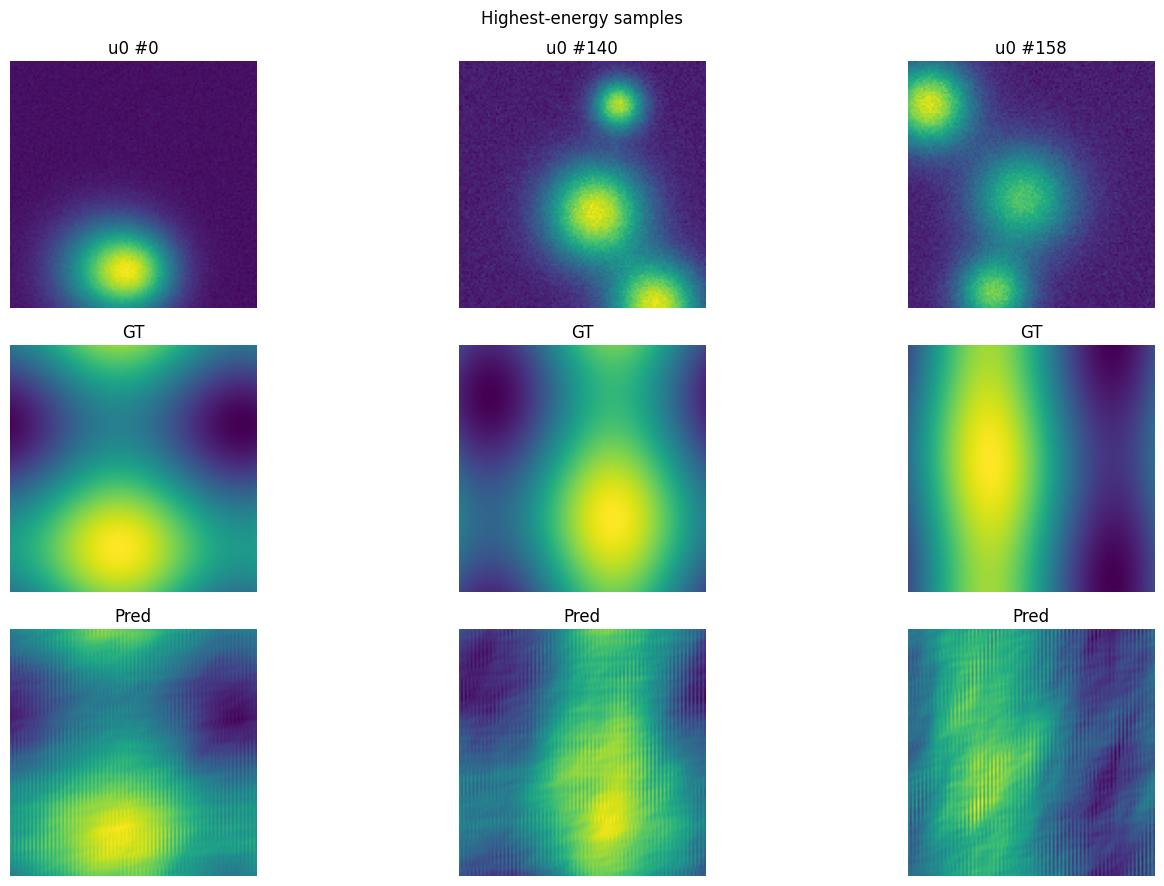

In [10]:
idx_energy = np.argsort(- np.sqrt(np.sum(y_test**2,(1,2,3))))

# quick viewer
def show_idx(idxs, title):
    import matplotlib.pyplot as plt
    import numpy as np
    k = min(3, len(idxs)); fig, ax = plt.subplots(3, k, figsize=(5*k, 9))
    for c,i in enumerate(idxs[:k]):
        ax[0,c].imshow(x_test[i,0]); ax[0,c].set_title(f'u0 #{i}'); ax[0,c].axis('off')
        ax[1,c].imshow(y_test[i,0]);  ax[1,c].set_title('GT');      ax[1,c].axis('off')
        ax[2,c].imshow(y_pred[i,0]);  ax[2,c].set_title('Pred');    ax[2,c].axis('off')
    fig.suptitle(title); plt.tight_layout(); plt.show()

show_idx(idx_energy, "Highest-energy samples")

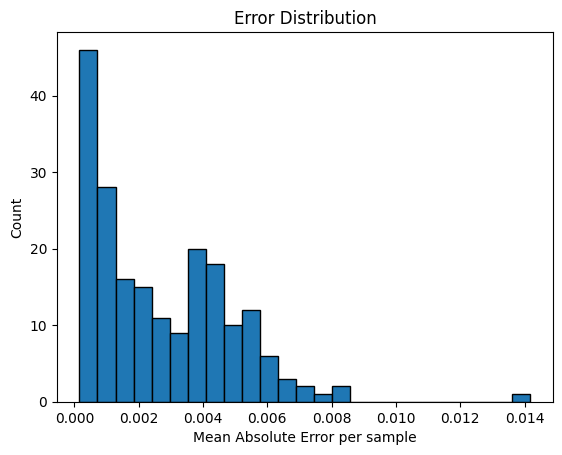

Mean: 0.002705623395740986 Std: 0.002172376960515976


In [11]:
errs = np.mean(np.abs(y_pred - y_test), axis=(1,2,3))
plt.hist(errs,bins=25,edgecolor='black')
plt.xlabel('Mean Absolute Error per sample')
plt.ylabel('Count'); plt.title('Error Distribution'); plt.show()
print('Mean:',float(np.mean(errs)),'Std:',float(np.std(errs)))